# <font color=blue size="10">Analyze fit tuning curves of "E"</font>

We use the functional derived from a difference of gaussians (Mexican hat) to fit the bandwidth tuning curves

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tqdm
from importlib import reload
#from tuning_curve_fit_funcs import carandini_fit_wStats
import tuning_curve_fit_funcs as tcfits
import tuning_curve_feature_plotting as tcfplot
reload(tcfits)
reload(tcfplot)

<module 'tuning_curve_feature_plotting' from '/Users/yashar/Google-Drive/Documents/Work/Projects/AuditoryContextualModul/Matlab/tuning_curve_feature_plotting.py'>

In [2]:
DATA_DIR = '/Users/yashar/Google-Drive/Documents/Work/Projects/AuditoryContextualModul/Matlab/Lakunina-Jaramillo-Data/'
filename = 'photoidentified_cells_responsesTCs_new.npz'
data = np.load(DATA_DIR + filename)
print("\n".join(data.keys())) #:gives the list of arrays in the file
data.close()

PVonsetResponses
PVsustainedResponses
SOMonsetResponses
SOMsustainedResponses
PVsustainedBaselineSpikeRates
ACsustainedResponses
stimulusBandwidth
AConsetBaselineSpikeRates
AConsetResponses
PVonsetBaselineSpikeRates
SOMsustainedBaselineSpikeRates
ACsustainedBaselineSpikeRates
SOMonsetBaselineSpikeRates


In [3]:
BLisZeroBW = True #whether to replace pure tone evoked rates with baseline (spontaneous) rates
WNoctave = 6 #what BW (in octaves) to attribute to white noise stimulus

# Fitting "E" cells

In [4]:
#fit all "E" cells 
Celltype = 'AC'
CelltypeLabel = '"E"'
Response_type = 'sustained'
mExp = None

ACfeatures = tcfits.FitAllCells(DATA_DIR + filename, Celltype, Response_type, BLisZeroBW,\
                             WNoctave,  mFixed=mExp, function_class_fit= "diff_of_gauss_fit")

  0%|          | 0/120 [00:00<?, ?it/s]/Users/yashar/Google-Drive/Documents/Work/Projects/AuditoryContextualModul/Matlab/tuning_curve_fit_funcs.py:221: RuntimeWarning: divide by zero encountered in double_scalars
  Stats['SuppInd'] = 1 - Stats['wnResp']/Stats['maxResp']
/Users/yashar/Google-Drive/Documents/Work/Projects/AuditoryContextualModul/Matlab/tuning_curve_fit_funcs.py:230: RuntimeWarning: divide by zero encountered in double_scalars
  RawStats['SuppInd'] = 1 - RawStats['wnResp']/RawStats['maxResp']
100%|██████████| 120/120 [00:21<00:00,  5.48it/s]


 Elapsed time was 21.8823 seconds


### Goodness of fit

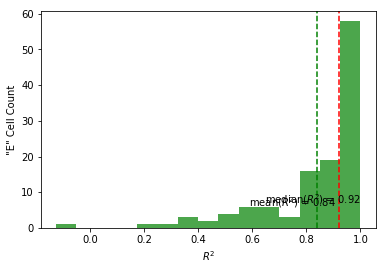

In [5]:
TCfeatures = eval(Celltype+'features')
test_BWs = TCfeatures['test_BWs']
Bandwidths = TCfeatures['Bandwidths']

%matplotlib inline

R2 = TCfeatures['GoF']['R2']
R2Label = TCfeatures['GoFLabels']['R2']
#fig = plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(R2, 15, facecolor='g',alpha=0.7)
plt.axvline(x=np.median(R2),c='r',linestyle='--')
plt.axvline(x=np.mean(R2),c='g',linestyle='--')
plt.xlabel(R2Label)
plt.ylabel(CelltypeLabel+ ' Cell Count')
plt.text(np.median(R2)*.7, 7, 'median('+R2Label+') = %1.2f' % np.median(R2))
plt.text(np.mean(R2)*.7, 6, 'mean('+R2Label+') = %1.2f' % np.mean(R2))
#plt.axis([40, 160, 0, 0.03])
#plt.grid(True)
plt.show()

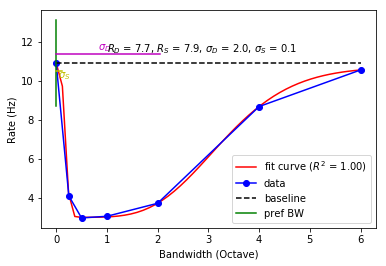

In [6]:
#visualize all fits, from worse to best
import pylab as pl
from IPython import display

R2inds = np.argsort(R2)
for cel in R2inds[:]:
    pl.clf()
    baseline = TCfeatures['Baselines'][cel]
    pl.plot(test_BWs,baseline + TCfeatures['fitTCs'][:,cel],'r-',label='fit curve ('+R2Label+' = %1.2f)' % R2[cel])
    pl.plot(Bandwidths, baseline + TCfeatures['rawTCs'][:,cel],'bo-',label='data')
    pl.plot(Bandwidths, baseline*(1+0*Bandwidths),'k--',label='baseline')
    ys = np.asarray(pl.gca().get_ylim())    
#    pl.text(np.mean(R2)*.7, 30, 'mean('+R2Label+') = %1.2f' % np.mean(R2))
    pl.plot(TCfeatures['MiscParams']['prefBW'][cel] + 0*ys, baseline + np.linspace(-.5,.5,2)*np.diff(ys)/2,'g-',label='pref BW')
    pl.plot(np.linspace(0,1,2)*TCfeatures['CarandiniParams']['sigmaD'][cel], 0*ys + baseline + np.diff(ys)/20,'m-')
    pl.plot(np.linspace(0,1,2)*TCfeatures['CarandiniParams']['sigmaS'][cel], 0*ys + baseline - np.diff(ys)/20,'y-')    
    pl.text(0.4*TCfeatures['CarandiniParams']['sigmaD'][cel], baseline + np.diff(ys)*1.5/20, '$\sigma_D$',color='m')
    pl.text(0.4*TCfeatures['CarandiniParams']['sigmaS'][cel], baseline - np.diff(ys)*1.7/20, '$\sigma_S$',color='y')

    pars = (TCfeatures['CarandiniParams']['RD'][cel], TCfeatures['CarandiniParams']['RS'][cel],TCfeatures['CarandiniParams']['sigmaD'][cel],TCfeatures['CarandiniParams']['sigmaS'][cel])
    pl.text(1,baseline*1.05,'$R_D$ = %2.1f, $R_S$ = %2.1f, $\sigma_D$ = %2.1f, $\sigma_S$ = %2.1f' % pars)
    pl.xlabel('Bandwidth (Octave)')
    pl.ylabel('Rate (Hz)')
    pl.legend()
    display.display(pl.gcf())
    display.clear_output(wait=True)
    time.sleep(.05)

R2 , AbsPrefBW , Baseline , SuppInd_noBL , SuppInd_wBL , peakAbsResp , peakNegResp , peakRate , peakResp , peakSignedResp , prefBW , wnRate , wnResp


/Users/yashar/miniconda3/envs/myenv/lib/python3.5/site-packages/numpy/lib/function_base.py:2923: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


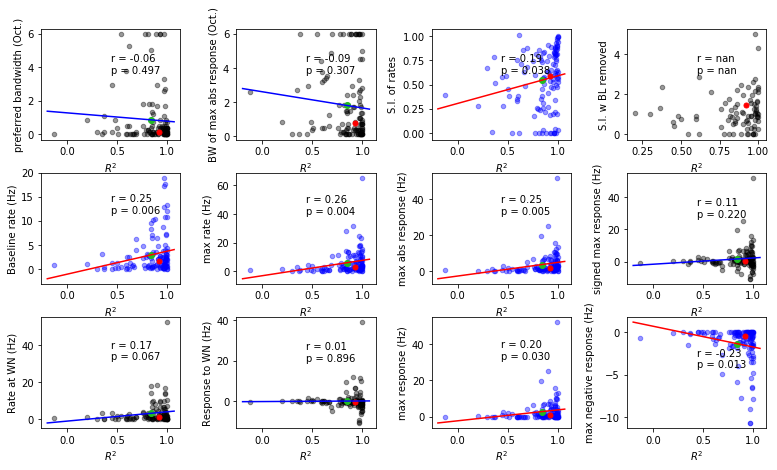

In [7]:
TCfeaturesToPlot = TCfeatures['MiscParams'].copy()#copying dictionary
TCfeaturesToPlot['R2'] = TCfeatures['GoF']['R2'] #adding R^2
TCparamNames = TCfeatures['MiscParamsNames'][:] #copying list
TCparamNames.insert(0,'R2')#'R2' is first name in list
print(" , ".join(TCparamNames))
ParamsLabels = TCfeatures['MiscParamsLabels'].copy()#copying dictionary
ParamsLabels['R2'] = TCfeatures['GoFLabels']['R2']

betterOrder = [10,1,4,3,2,7,5,9,11,12,8,6]
ylist = range(1,12+1)
pairs = [[0, betterOrder[k-1]] for k in ylist] 
tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, pairs,figsize=(13,10),cols=4,wspace=.4,linecolor='r')

del(TCfeaturesToPlot,ParamsLabels,TCparamNames)

<style type="text/css">
body  {
   background-color:#E8E2E8;
};
</style>
<font color=#dd8010 size="4">
So there seems to be a weak relationship: cells with stronger response/rate have better fits

R2 , R0 , RD , RS , m , sigmaD , sigmaS


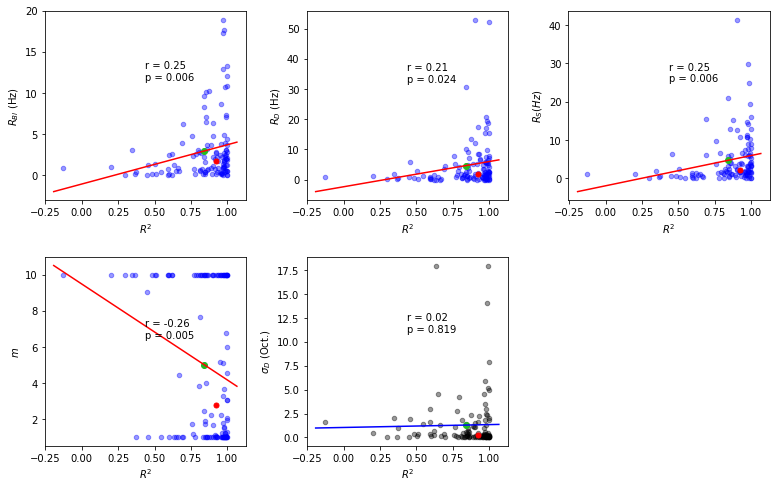

In [8]:
TCfeaturesToPlot = TCfeatures['CarandiniParams'].copy()#copying dictionary
TCfeaturesToPlot['R2'] = TCfeatures['GoF']['R2'] #adding R^2
TCparamNames = TCfeatures['CarandiniParamsNames'][:] #copying list
TCparamNames.insert(0,'R2')#'R2' is first name in list
print(" , ".join(TCparamNames))
ParamsLabels = TCfeatures['CarandiniParamsLabels'].copy()#copying dictionary
ParamsLabels['R2'] = TCfeatures['GoFLabels']['R2']

#betterOrder = [10,1,4,3,2,7,5,9,11,12,8,6]
ylist = range(1,6)
betterOrder = ylist
pairs = [[0, betterOrder[k-1]] for k in ylist] 
tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, pairs,figsize=(13,8),cols=3,wspace=.3,linecolor='r')

del(TCfeaturesToPlot,ParamsLabels,TCparamNames)

## Tuning curve feature distributions

In [9]:
TCfeatures = eval(Celltype+'features')

TCfeaturesToPlot = TCfeatures['MiscParams']
TCparamNames = TCfeatures['MiscParamsNames']
ParamsLabels = TCfeatures['MiscParamsLabels']
print(" , ".join(TCparamNames))

AbsPrefBW , Baseline , SuppInd_noBL , SuppInd_wBL , peakAbsResp , peakNegResp , peakRate , peakResp , peakSignedResp , prefBW , wnRate , wnResp


/Users/yashar/miniconda3/envs/myenv/lib/python3.5/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Ncells = 120


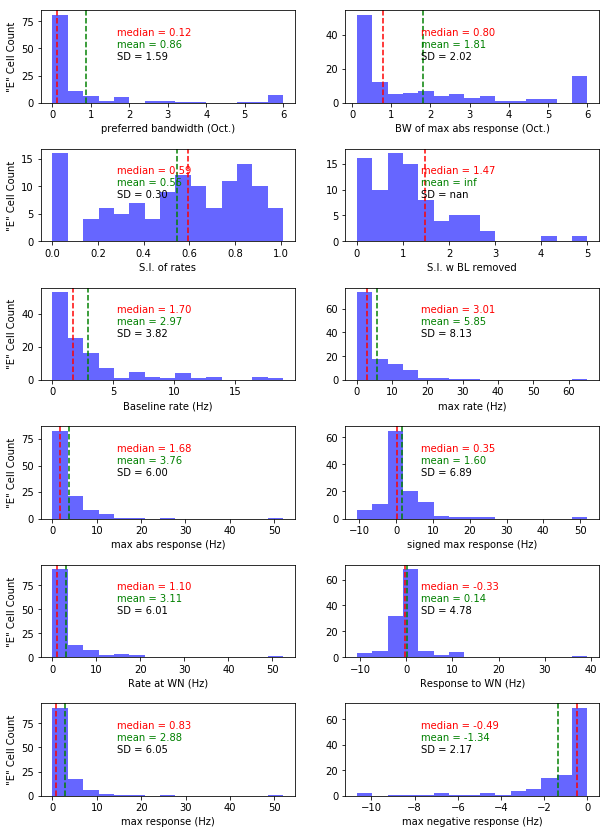

In [10]:
%matplotlib inline

betterOrder = [10,1,4,3,2,7,5,9,11,12,8,6]
tcfplot.makeHistograms(TCfeaturesToPlot, TCparamNames,ParamsLabels, CelltypeLabel,betterOrder,nbins=15)
print("Ncells = %1.0f" % TCfeatures['Ncells'])

/Users/yashar/miniconda3/envs/myenv/lib/python3.5/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Ncells = 120


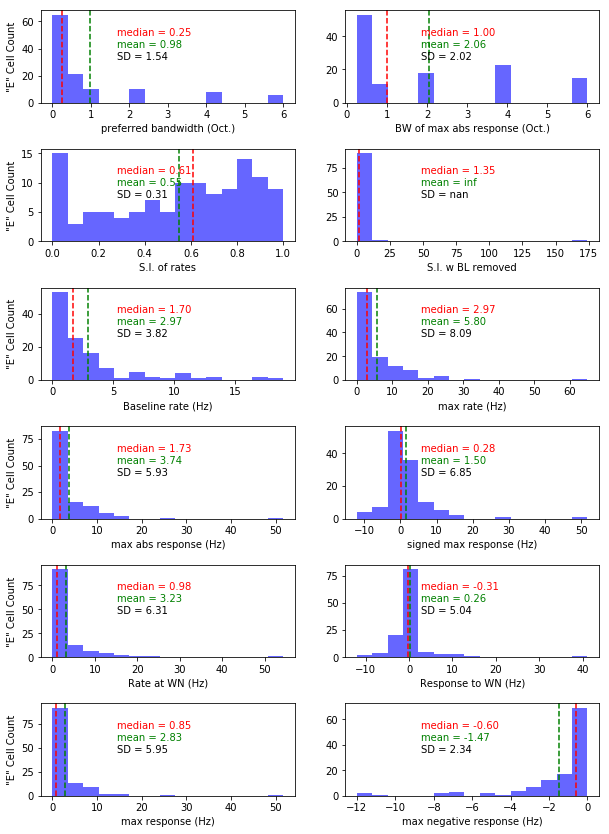

In [11]:
betterOrder = [10,1,4,3,2,7,5,9,11,12,8,6]
tcfplot.makeHistograms(TCfeatures['RawMiscParams'], TCparamNames,ParamsLabels, CelltypeLabel,betterOrder,nbins=15)
print("Ncells = %1.0f" % TCfeatures['Ncells'])

/Users/yashar/miniconda3/envs/myenv/lib/python3.5/site-packages/numpy/lib/function_base.py:2923: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]




 Comparing raw (y-axis) vs. fit-curve-extracted TC features


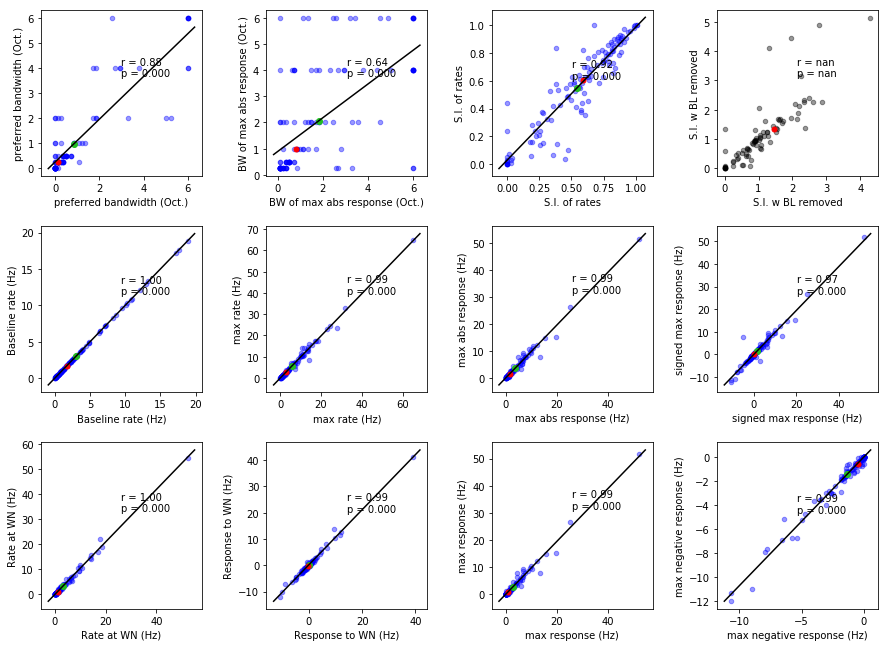

In [12]:
n_ftr = 12
pairs = list(zip(range(n_ftr),range(n_ftr)))
betterOrder = [10,1,4,3,2,7,5,9,11,12,8,6]
pairs = [[betterOrder[i]-1 for i in p] for p in pairs] 
tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels,\
                         pairs,figsize=(15,15),cols=4,hspace = .3, wspace = .4,\
                        yTCfeatures = TCfeatures['RawMiscParams'])
print("\n\n Comparing raw (y-axis) vs. fit-curve-extracted TC features")

#### Correlations of preferred BW with other quantities:

array([ 0.,  0.,  0.,  0.,  1.,  1.,  0.])

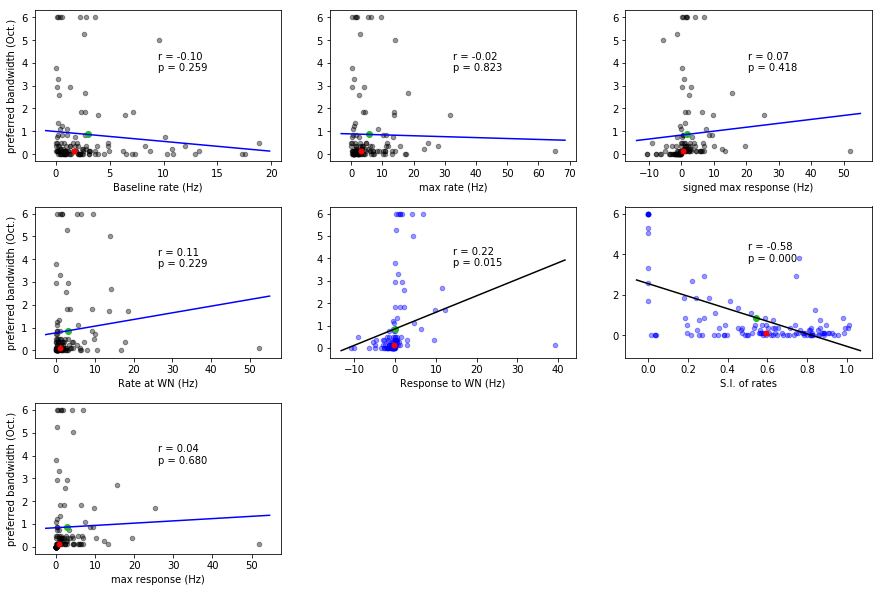

In [13]:
pairs = [(5,1),(6,1),(8,1),(9,1),(10,1),(3,1),(11,1)]
pairs = [[betterOrder[i-1]-1 for i in p] for p in pairs] 
tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, pairs,uniformYs=True,figsize=(15,10))

#### Correlations of *Suppression Index* with other quantities:

array([ 1.,  1.,  0.,  1.,  1.,  1.,  0.])

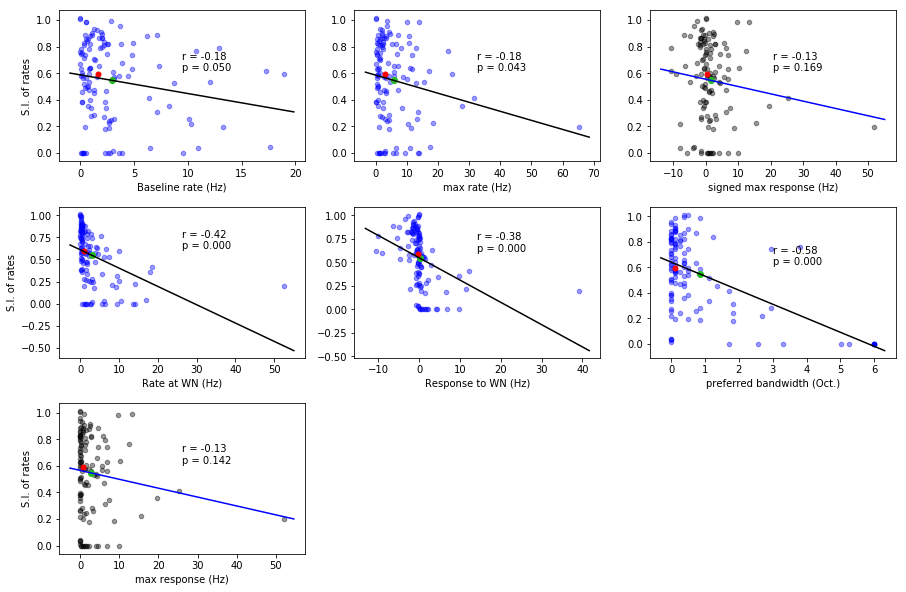

In [14]:
pairs = [(5,3),(6,3),(8,3),(9,3),(10,3),(1,3),(11,3)]
pairs = [[betterOrder[i-1]-1 for i in p] for p in pairs] 
tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, pairs,uniformYs=True,figsize=(15,10))

#### Correlations of rates and responses (not interesting)

array([ 0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

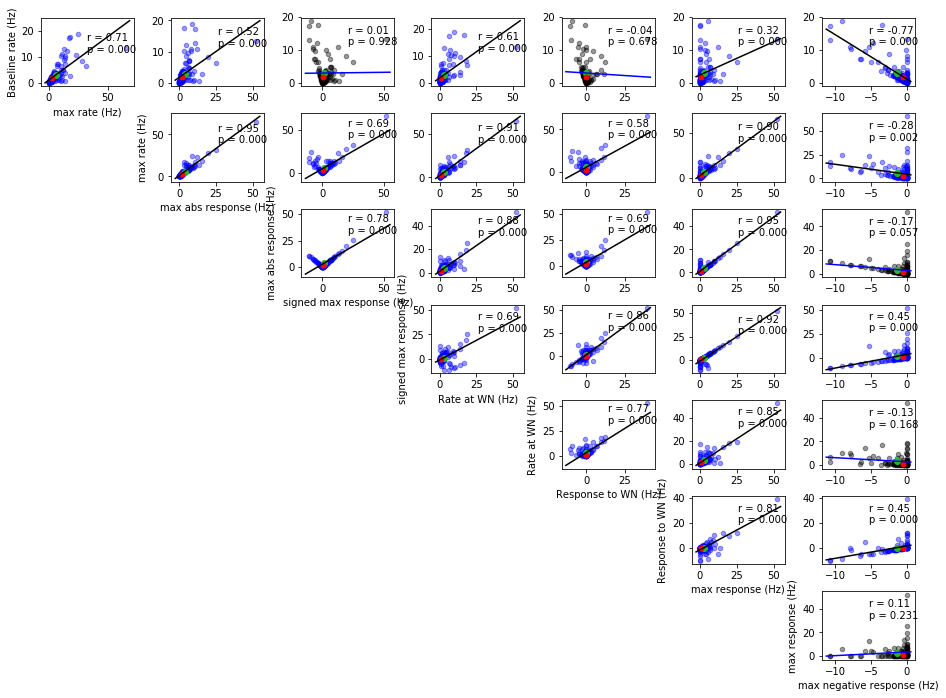

In [15]:
inds = range(5,13) #for rates
pairs = [(j,i) for i in inds for j in inds]
pairs = [[betterOrder[i-1]-1 for i in p] for p in pairs] 
tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, \
                 pairs,cols=len(inds),figsize=(27/1.5,23/1.5),hspace=.4,wspace=.4,uniformYs=True,symm=True)

## Difference of Gaussians parameters

In [16]:
TCfeatures = eval(Celltype+'features')

TCfeaturesToPlot = TCfeatures['CarandiniParams']
TCparamNames = TCfeatures['CarandiniParamsNames']
ParamsLabels = TCfeatures['CarandiniParamsLabels']
print(" , ".join(TCparamNames))

R0 , RD , RS , m , sigmaD , sigmaS


Ncells = 120


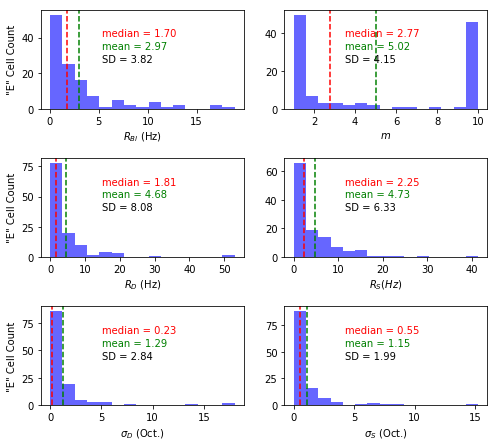

In [17]:
%matplotlib inline

betterOrder = [1,4,2,3,5,6] #list(range(1,7))
tcfplot.makeHistograms(TCfeaturesToPlot, TCparamNames,ParamsLabels, CelltypeLabel,betterOrder,figsize=(8,10),nbins=15)
print("Ncells = %1.0f" % TCfeatures['Ncells'])

array([ 0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

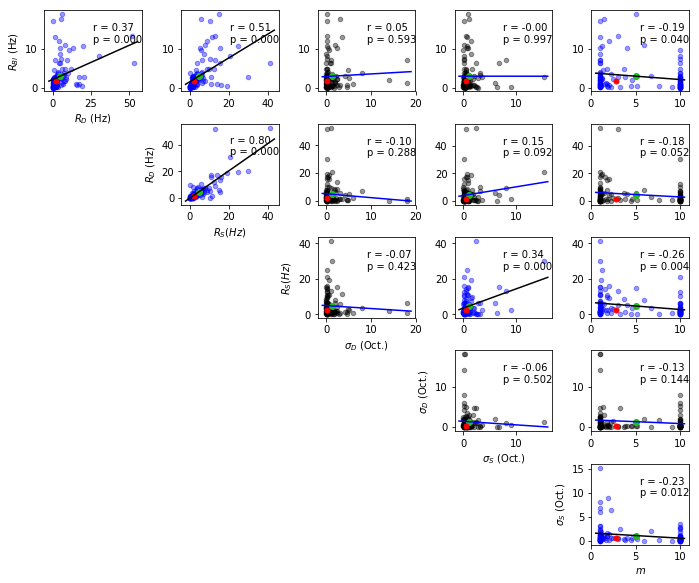

In [18]:
inds = range(6)
pairs = [(j,i) for i in inds for j in inds]
betterOrder = [1,2,3,5,6,4]
pairs = [[betterOrder[i]-1 for i in p] for p in pairs] 
tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, \
                 pairs,cols=len(inds),figsize=(14,14),hspace=.4,wspace=.4,symm=True)

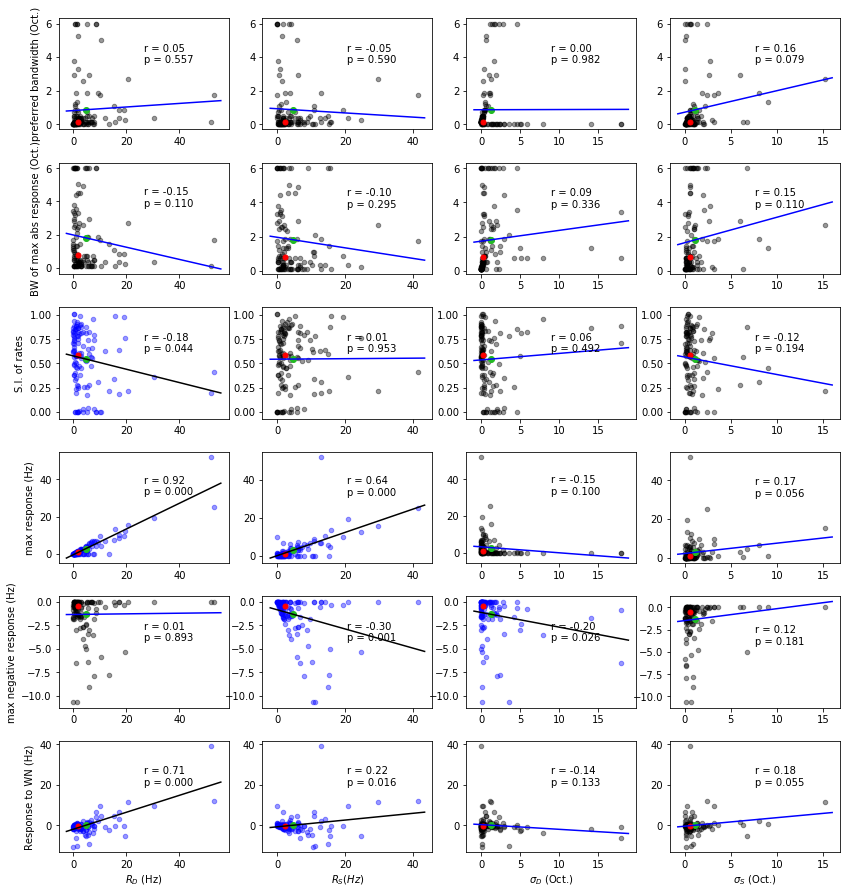

In [19]:
betterOrder_x = [2,3,5,6]
betterOrder_y = [10,1,4,8,6,12]
pairs = [[i-1, j-1] for j in betterOrder_y for i in betterOrder_x ] 
sig_vec = tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, \
                 pairs,cols=len(betterOrder_x),figsize=(14,18),hspace=.3,wspace=.2,uniformYs=True,uniformXs=True,\
                 yTCfeatures = TCfeatures['MiscParams'],yTCparamsNames = TCfeatures['MiscParamsNames'],\
                         yTCparamsLabels = TCfeatures['MiscParamsLabels'])

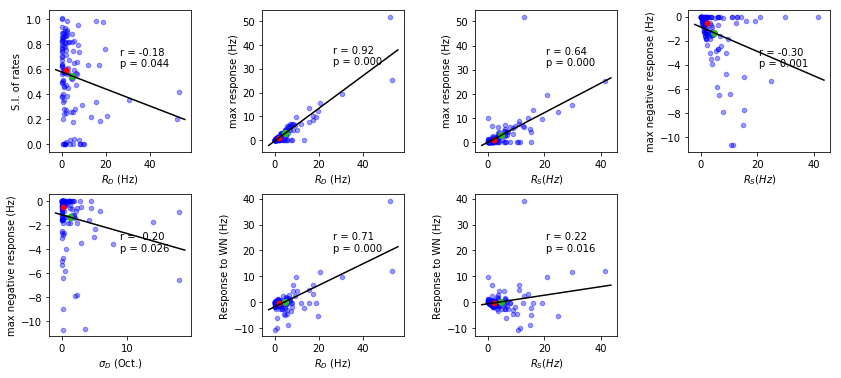

In [20]:
pairs1 = [pairs[i] for i in np.nonzero(sig_vec)[0]]
sigs = tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, \
                 pairs1,cols=len(betterOrder_x),figsize=(14,6),wspace=.5,\
                 yTCfeatures = TCfeatures['MiscParams'],yTCparamsNames = TCfeatures['MiscParamsNames'],\
                         yTCparamsLabels = TCfeatures['MiscParamsLabels'])